# **----------------------**>**HOUSE PRICE PREDICTION PROJECT**<**----------------------**

# Step 1: Import Libraries

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.impute import SimpleImputer
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, r2_score
import warnings

# Suppress warnings
warnings.filterwarnings("ignore")


# Step 2: Load and Inspect Data

In [2]:
# Load data
train_data = pd.read_csv('D:\# DATA SCIENCE\# PROJECTS\- PROJECTS INTERNSHIPS\TECHNOHACKS SOLUTIONS - MACHINE LEARNING ENGINEERING\House Prices Prediction Project\house-prices-advanced-regression-techniques/train.csv')
test_data = pd.read_csv('D:\# DATA SCIENCE\# PROJECTS\- PROJECTS INTERNSHIPS\TECHNOHACKS SOLUTIONS - MACHINE LEARNING ENGINEERING\House Prices Prediction Project\house-prices-advanced-regression-techniques/test.csv')

# Inspect the data
print(train_data.head())
print(test_data.head())

# Display basic info
print(train_data.info())
print(test_data.info())


   Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD   

# Step 3: Data Exploration, Cleaning, and Engineering

### Step 3.1: Exploratory Data Analysis (EDA)

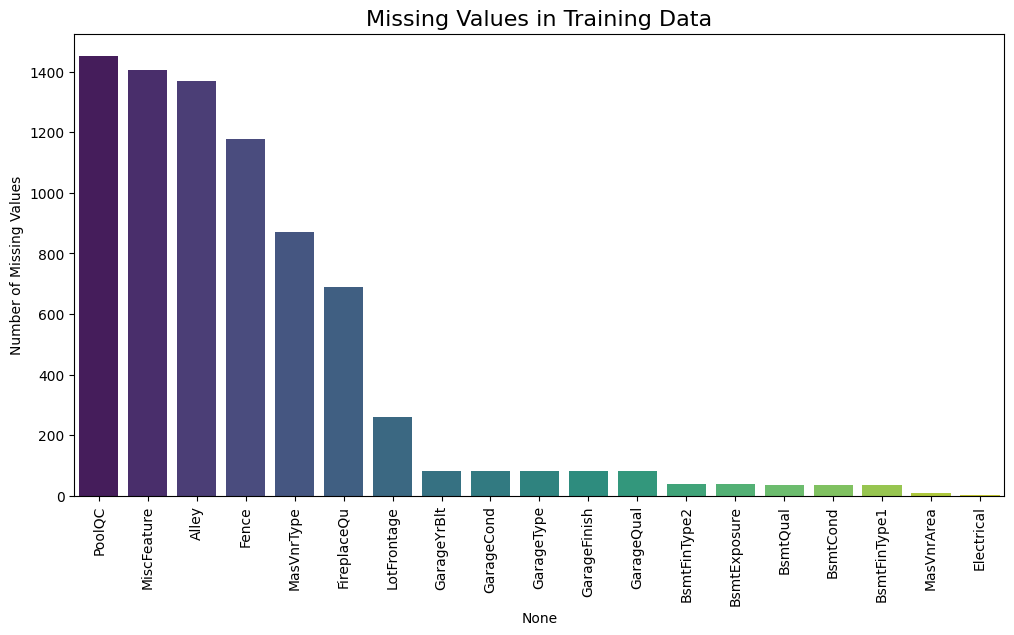

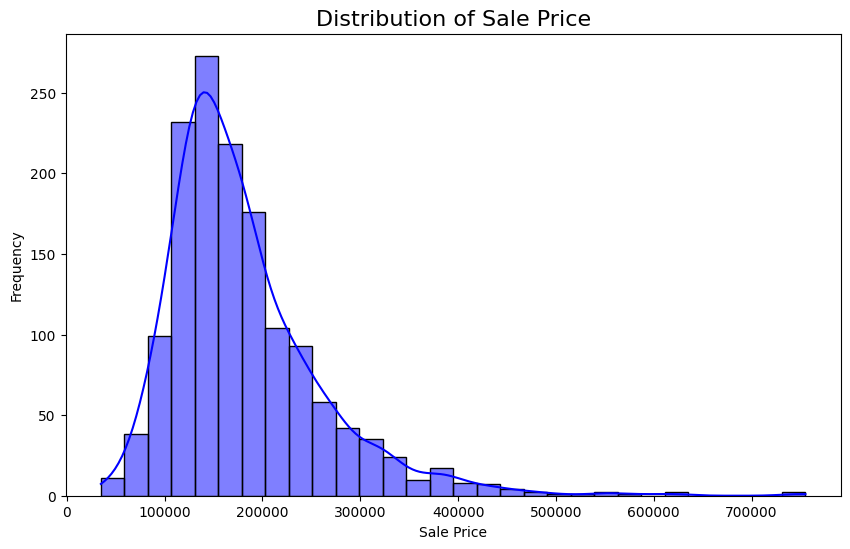

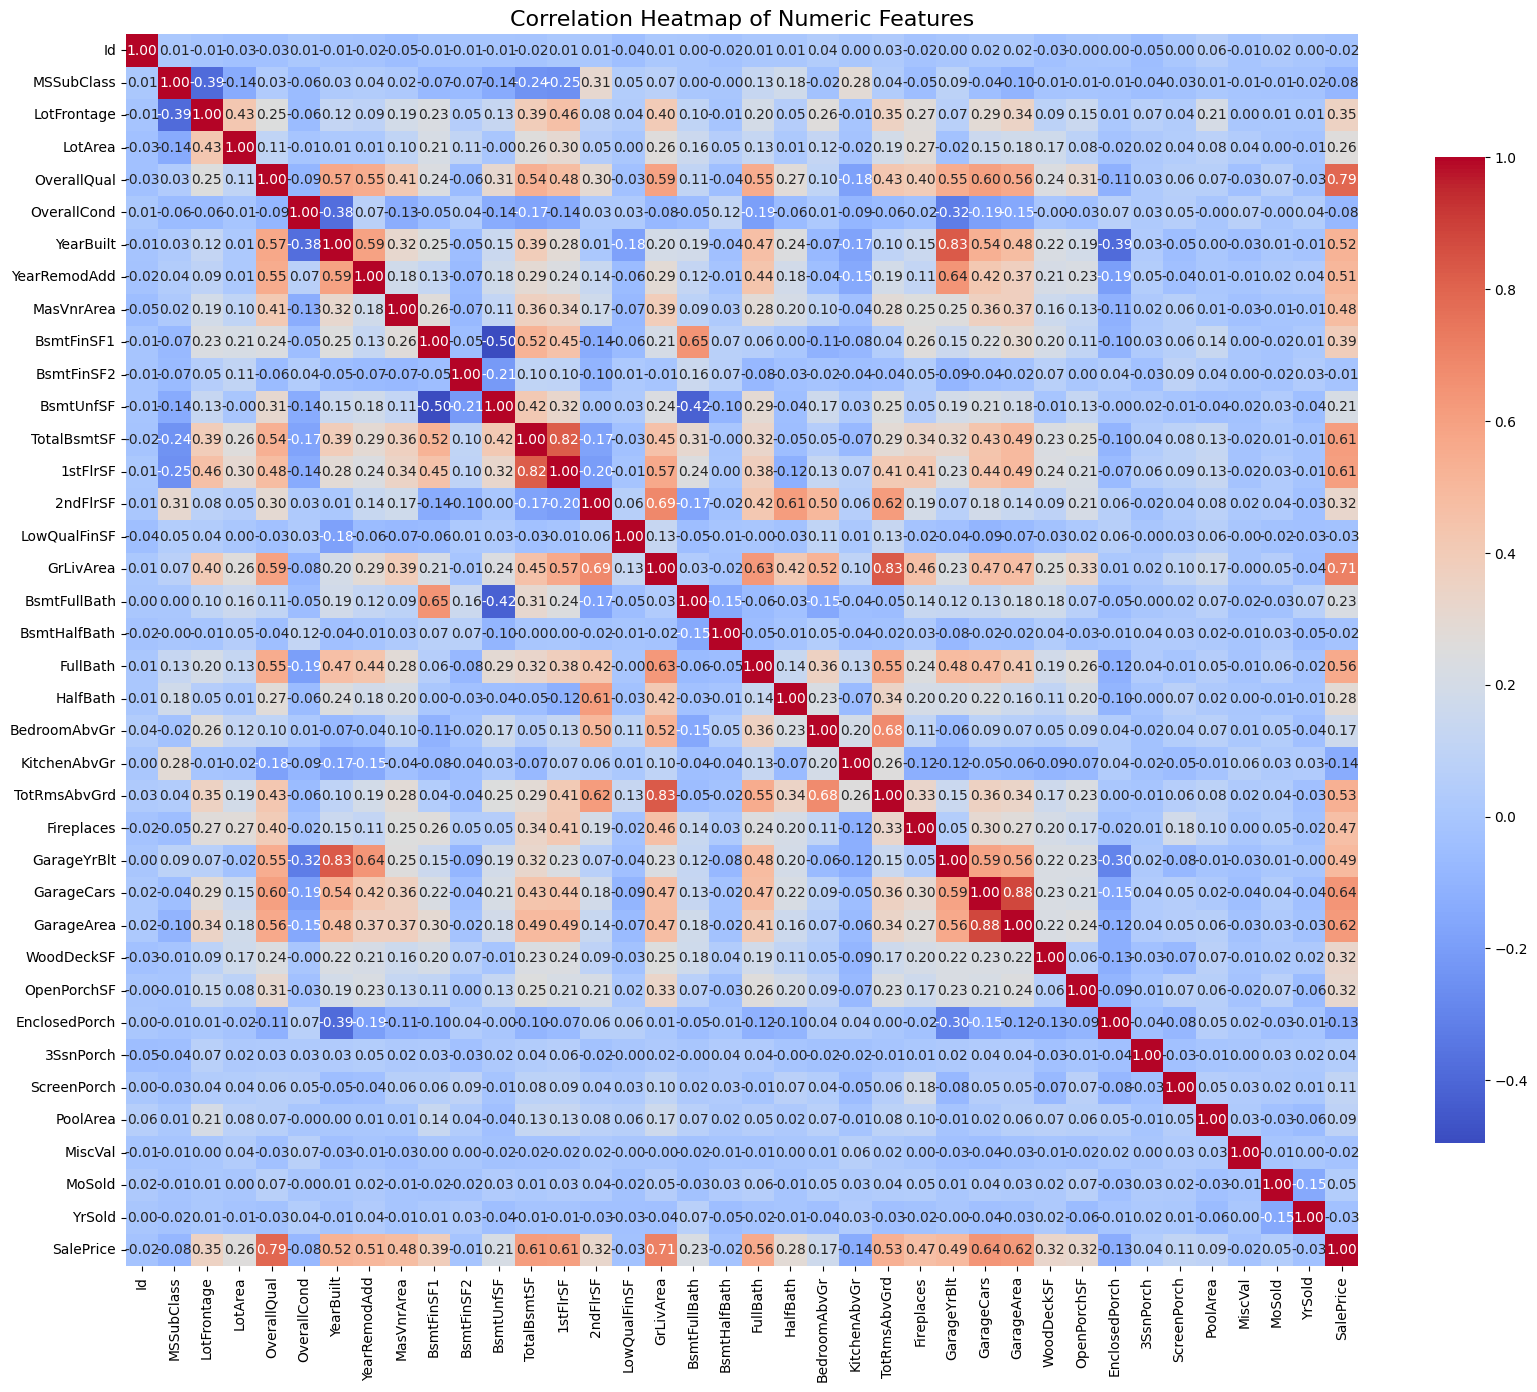

In [3]:
# Check for missing values
missing_values = train_data.isnull().sum().sort_values(ascending=False)
missing_values = missing_values[missing_values > 0]
plt.figure(figsize=(12, 6))
sns.barplot(x=missing_values.index, y=missing_values.values, palette='viridis')
plt.title('Missing Values in Training Data', fontsize=16)
plt.xticks(rotation=90)
plt.ylabel('Number of Missing Values')
plt.show()

# Visualizing the distribution of SalePrice
plt.figure(figsize=(10, 6))
sns.histplot(train_data['SalePrice'], bins=30, kde=True, color='blue')
plt.title('Distribution of Sale Price', fontsize=16)
plt.xlabel('Sale Price')
plt.ylabel('Frequency')
plt.show()

# Correlation heatmap of numeric features
plt.figure(figsize=(20, 16))
# Select only numeric columns for correlation
numeric_cols = train_data.select_dtypes(include=['int64', 'float64']).columns
corr_matrix = train_data[numeric_cols].corr()
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', square=True, cbar_kws={"shrink": .8})
plt.title('Correlation Heatmap of Numeric Features', fontsize=16)
plt.show()


### Step 3.2: Handle Missing Values

In [4]:
# Impute only on features common to both train and test datasets
common_cols = train_data.columns.intersection(test_data.columns)

# Select numeric columns common to both train and test data
num_cols = train_data[common_cols].select_dtypes(include=['int64', 'float64']).columns

# Imputer for numeric columns
imputer = SimpleImputer(strategy='median')

# Fit and transform on training data
train_data[num_cols] = imputer.fit_transform(train_data[num_cols])

# Transform test data
test_data[num_cols] = imputer.transform(test_data[num_cols])


### Step 3.3: Feature Engineering

In [5]:
# Encode categorical features
train_data_encoded = pd.get_dummies(train_data)
test_data_encoded = pd.get_dummies(test_data)

# Align columns in test_data to match train_data
test_data_encoded = test_data_encoded.reindex(columns=train_data_encoded.columns, fill_value=0)


# Step 4: Train-Test Split

In [6]:
# Define features and target
X = train_data_encoded.drop('SalePrice', axis=1)
y = train_data_encoded['SalePrice']

# Split the data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)


# Step 5: Scaling Features

In [7]:
# Standardize features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled = scaler.transform(X_val)


# Step 6: Hyperparameter Tuning using Grid Search

pip install numba
nvidia-smi

In [8]:
from numba import cuda

# Check if a GPU is available
if cuda.is_available():
    print("CUDA is available. GPU detected.")
else:
    print("CUDA is not available. No GPU detected.")


CUDA is available. GPU detected.


In [9]:
from xgboost import XGBRegressor

param_grid = {
    'n_estimators': [100, 200, 300],
    'learning_rate': [0.01, 0.05, 0.1],
    'max_depth': [3, 4, 5, 6],
    'min_child_weight': [1, 2, 3],
    'subsample': [0.7, 0.8, 0.9],
    'colsample_bytree': [0.7, 0.8, 0.9],
    'tree_method': ['gpu_hist']  # Use GPU
}

grid_search = GridSearchCV(estimator=XGBRegressor(random_state=42), 
                           param_grid=param_grid, 
                           scoring='r2', 
                           cv=3, 
                           verbose=1)

grid_search.fit(X_train_scaled, y_train)

# Get the best model
best_model = grid_search.best_estimator_


Fitting 3 folds for each of 972 candidates, totalling 2916 fits


# Step 8: Model Evaluation

In [35]:
# Predict on validation data
val_predictions = best_model.predict(X_val_scaled)

# Calculate metrics
r2 = r2_score(y_val, val_predictions)
print(f'Validation R^2 Score: {r2}')


Validation R^2 Score: 0.9122692305578548


# Step 9: Visualization

### Step 9.1: Prediction vs Actual Values

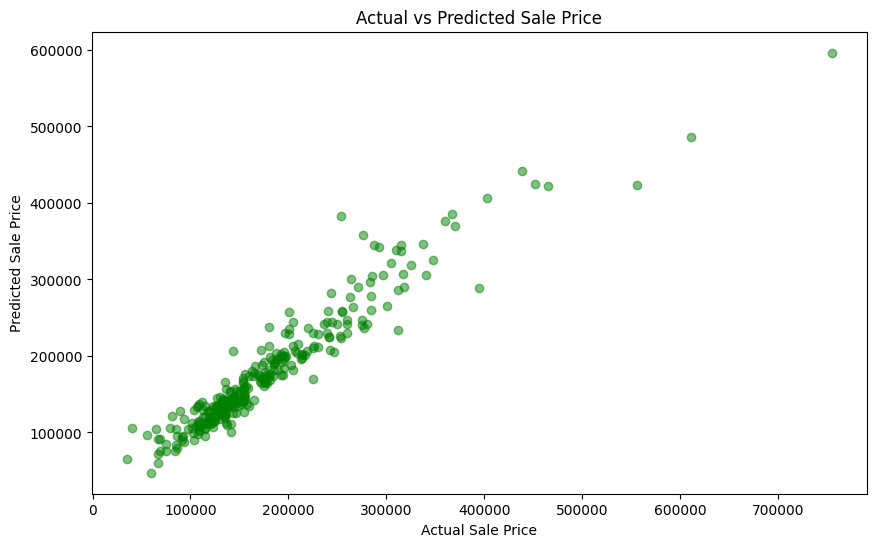

In [36]:
# Plot predictions vs actual values
plt.figure(figsize=(10, 6))
plt.scatter(y_val, val_predictions, color='green', alpha=0.5)
plt.xlabel('Actual Sale Price')
plt.ylabel('Predicted Sale Price')
plt.title('Actual vs Predicted Sale Price')
plt.show()


### Step 9.2: Error Visualization

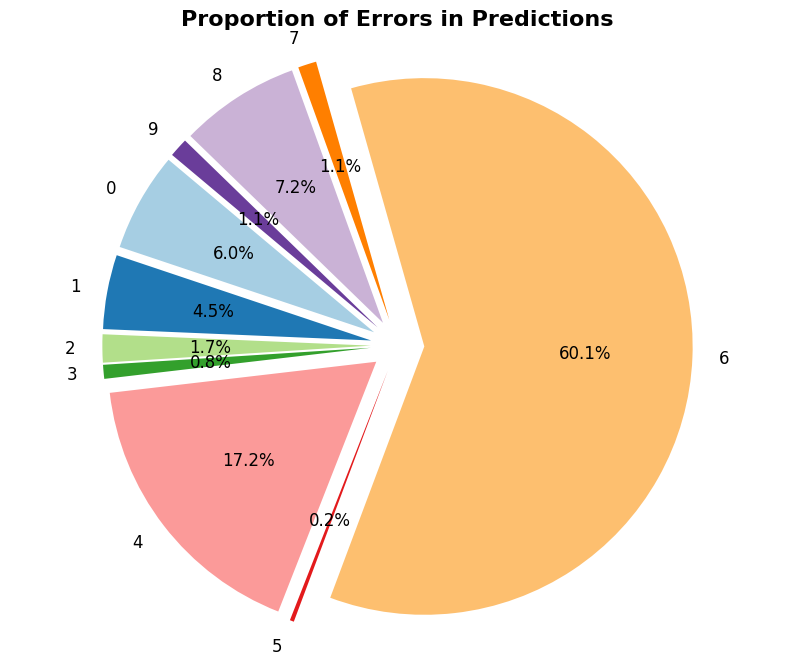

In [37]:
# Calculate the absolute errors
errors = np.abs(y_val - val_predictions)

# Plot pie chart
plt.figure(figsize=(10, 8))
plt.title('Proportion of Errors in Predictions', fontsize=16, fontweight='bold')

# Pie chart parameters
colors = plt.cm.Paired(np.arange(len(errors)))  # Use a colormap for better color distinction
explode = [0.1] * len(errors[:10])  # Slightly explode each slice for better visibility

# Plot pie chart for the top 10 errors
plt.pie(errors[:10], labels=np.arange(10), colors=colors,
        autopct='%1.1f%%', startangle=140, explode=explode, textprops={'fontsize': 12})

plt.axis('equal')  # Equal aspect ratio ensures that pie is drawn as a circle.
plt.show()


Step 10: Final Predictions

In [38]:
# Prepare and save final predictions
X_test = test_data_encoded.drop('SalePrice', axis=1, errors='ignore')  
X_test_scaled = scaler.transform(X_test)
test_predictions = best_model.predict(X_test_scaled)

# Save predictions to a CSV file
submission = pd.DataFrame({'Id': test_data['Id'], 'SalePrice': test_predictions})
submission.to_csv('house_price_predictions_xgb_tuned.csv', index=False)
